In [5]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import cv2
import sys
import math
from pathlib import Path
from compress_pickle import dump, load

PIPELINE_ROOT = Path('./').resolve().parent.parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())
print(PIPELINE_ROOT)

from src.library.utilities.utilities_process import read_image, write_image
from src.library.cell_labeling.cell_utilities import calculate_correlation_and_energy, find_connected_segments, load_image, subtract_blurred_image



/home/eddyod/programming/pipeline


In [6]:
def show_image(img, increaser=1, _title="", fsize=[15,15]):
    plt.figure(figsize=[15,15])
    plt.imshow(img * increaser, cmap="gray")
    plt.title(_title,fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()

def collect_positives(uimg, startr, startc, tile_width, tile_height):
    img=np.copy(uimg)
    positives=[]
    radius = 80
    a=int(radius/2)
    color = (65000)
    min_row,min_col = startr, startc
    for index,r in df.iterrows():
        colr = r['x']
        rowr = r['y']
        col = int(round(r['x'])-min_col)
        row = int(round(r['y'])-min_row)
        if (col<0) or (col>tile_width) or (row<0) or (row>tile_height):
            continue
        img=cv2.circle(img, (int(col), int(row)), radius, color, 20)
        I=uimg[row-a:row+a,col-a:col+a]
        if I.shape==(radius,radius):
            positives.append((col,row,I, colr, rowr))

    return img,positives

def calc_moments_of_mask(mask):   
    mask = mask.astype(np.float32)
    moments = cv2.moments(mask)

    huMoments = cv2.HuMoments(moments)
    moments = append_string_to_every_key(moments, f'_mask')
    return (moments, {'h%d'%i+f'_mask':huMoments[i,0]  for i in range(7)}) #return first 7 Hu moments e.g. h1_mask

def mask_mean(mask,image):
    ids, counts = np.unique(mask, return_counts=True)
    print(ids, len(ids))
    print(mask.dtype)
    mean_in=np.mean(image[mask==1])
    print(f'mean_in {mean_in}')
    mean_all=np.mean(image.flatten())
    return (mean_in-mean_all)/(mean_in+mean_all)    # calculate the contrast: mean

def append_string_to_every_key(dictionary, post_fix): 
    return dict(zip([keyi + post_fix for keyi in dictionary.keys()],dictionary.values()))

def features_using_center_connected_components(cell_candidate_data):   
    '''Part of step 3. calculate cell features'''

    mask = cell_candidate_data['mask']  

    moments_data = calc_moments_of_mask(mask)

    # Calculate constrasts relative to mask
    ch1_contrast = mask_mean(mask, cell_candidate_data['image_CH1'])
    ch3_constrast = mask_mean(mask, cell_candidate_data['image_CH3'])

    return ch1_contrast, ch3_constrast, moments_data


In [7]:
animal = 'DK184'
section = 0
channel = 3
prep_path = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'

In [8]:
tif = str(section).zfill(3) + ".tif"
filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
full_img = read_image(filepath)
full_img.shape

(25000, 30000)

In [9]:
dfpath = os.path.join(prep_path, 'cell_labels', 'all_predictions.csv')
df = pd.read_csv(dfpath)
df = df.loc[df['section'] == section]
df = df.sort_values(['section', 'y', 'x'])
df.head()

,x,y,section
0,26346.0,5718.0,0


In [10]:
#startc = int(round(min(df['x']), -3)) - 1000
#startr = int(round(min(df['y']), -3)) - 1000
#endc = math.ceil(max(df['x'])) + 100
#endr = math.ceil(max(df['y'])) + 100
# manually set to ROI
startr = 0
endr = startr + full_img.shape[0]
startc = 0
endc = startc + full_img.shape[1]
print(startr, endr, startc, endc)

0 25000 0 30000


In [11]:
tile_width = endc - startc
tile_height = endr - startr
img = full_img[startr:endr, startc:endc]
print(f'{startr}:{endr}, {startc}:{endc}')
print(img.shape)
print(f'{tile_width=} {tile_height=}')
#img.shape # (6800, 30000)

0:25000, 0:30000
(25000, 30000)
tile_width=30000 tile_height=25000


In [12]:
annotated_img, positives = collect_positives(full_img, startr, startc, tile_width, tile_height)
print(len(positives))

1


In [13]:
tif = str(section).zfill(3) + ".tif"
filepath = os.path.join(prep_path, f'C{channel}/full_aligned', tif)
input_file_virus_path = os.path.join(prep_path, 'C3/full_aligned', tif)  
input_file_dye_path = os.path.join(prep_path, 'C1/full_aligned', tif)  
data_virus = read_image(input_file_virus_path)
data_dye = read_image(input_file_dye_path)
print(f'{data_virus.shape=} {data_dye.shape=}')

data_virus.shape=(25000, 30000) data_dye.shape=(25000, 30000)


In [14]:
avg_cell_img_file_path = '/net/birdstore/Active_Atlas_Data/cell_segmentation/models/average_cell_image.pkl'
avg_cell_img = load(avg_cell_img_file_path) #Load average cell image once
avg_cell_CH1 = avg_cell_img['CH1']
avg_cell_CH3 = avg_cell_img['CH3']

print(avg_cell_CH1.shape)

(80, 80)


In [15]:
cell = 0
col = positives[cell][1]
row = positives[cell][0]
control_img = positives[cell][2]
section = 0
print(f'processing coordinates {col=}, {row=}, {section=}')
idx = 0

startc = col - 40
endc = startc + 80
startr = row - 40
endr = startr + 80
row_start = startr
row_end = endr
col_start = startc
col_end = endc

print(f'{startr=} {endr=} {startc=} {endc=}')

processing coordinates col=5718, row=26346, section=0
startr=26306 endr=26386 startc=5678 endc=5758


In [16]:
image_roi_virus = data_virus[startc:endc, startr:endr] #image_roi IS numpy array
image_roi_dye = data_dye[startc:endc, startr:endr] #image_roi IS numpy array
print(f'shape of image_roi_virus {image_roi_virus.shape} and shape of data_virus {image_roi_dye.shape}')
absolute_coordinates = (startc, endc, startr, endr)
difference_ch1 = subtract_blurred_image(image_roi_dye, make_smaller=False) #calculate img difference for virus channel (e.g. fluorescence)
difference_ch3 = subtract_blurred_image(image_roi_virus, make_smaller=False) #calculate img difference for virus channel (e.g. fluorescence)


shape of image_roi_virus (80, 80) and shape of data_virus (80, 80)


shape of data_dye (25000, 30000)
row=26346 col=5718 startr=26306 endr=26386 startc=5678 endc=5758


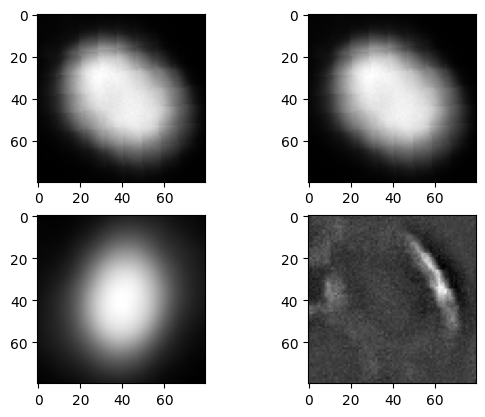

In [17]:
print(f'shape of data_dye {data_dye.shape}')
print(f'{row=} {col=} {startr=} {endr=} {startc=} {endc=}')
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(image_roi_virus, cmap="gray")
axarr[0,1].imshow(control_img, cmap="gray")
axarr[1,0].imshow(avg_cell_CH1, cmap="gray")
axarr[1,1].imshow(difference_ch1, cmap="gray")


In [18]:
connected_segments = find_connected_segments(image_roi_virus, 2000)
n_segments, segment_masks, segment_stats, segment_location = (connected_segments)
print(f'shape of segmentmasks {segment_masks.shape}')
#segment_masks[segment_masks > 0 ] = 255

ids, counts = np.unique(segment_masks, return_counts=True)
print(ids)
print(counts)
print(segment_masks.dtype)

shape of segmentmasks (80, 80)
[0 1 2]
[2249 4150    1]
int32


In [19]:
cell_radius = 0
n_segments, segment_masks, segment_stats, segment_location = (connected_segments)
for segmenti in range(n_segments):
    _, _, width, height, object_area = segment_stats[segmenti, :]
    segment_row, segment_col = segment_location[segmenti, :]
    #print(segment_row, segment_col)
    row_start = 0
    col_start = 0
    row_end = 80
    col_end = 80
    print(row_start, row_end, col_start, col_end)
    segment_mask = (segment_masks[row_start:row_end, col_start:col_end] == segmenti)
print(segment_mask.dtype)
ids, counts = np.unique(segment_mask, return_counts=True)
print(ids, counts)


0 80 0 80
0 80 0 80
0 80 0 80
bool
[False  True] [6399    1]


[False  True] [2825 3575]
detected mask dtype bool (80, 80)
[0 1 2] [2249 4150    1]
segment masks dtype int32 (80, 80)


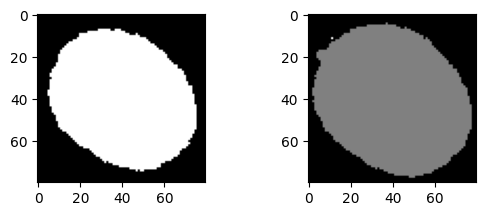

In [20]:
maskpath = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK184/preps/mask.npy'
detected_mask = np.load(maskpath)
ids, counts = np.unique(detected_mask, return_counts=True)
print(ids, counts)
print('detected mask dtype', detected_mask.dtype, detected_mask.shape)
#plt.imshow(mask.T, cmap="gray")
#plt.show()
#segment_masks[segment_masks > 0] = 255
ids, counts = np.unique(segment_masks, return_counts=True)
print(ids, counts)
print('segment masks dtype', segment_masks.dtype, segment_masks.shape)
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(detected_mask, cmap="gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(segment_masks, cmap="gray")

In [22]:
ids, counts = np.unique(detected_mask, return_counts=True)
print(ids, counts)
ids, counts = np.unique(segment_masks, return_counts=True)
print(ids, counts)

[False  True] [2825 3575]
[0 1 2] [2249 4150    1]


In [23]:
ch1_corr, ch1_energy = calculate_correlation_and_energy(avg_cell_img["CH1"], image_roi_dye)
ch3_corr, ch3_energy = calculate_correlation_and_energy(avg_cell_img["CH3"], image_roi_virus)
print(ch1_corr, ch1_energy)


-0.06482243057566793 0.03444637049021868


In [24]:
cell = {
    "area": 6400,
    "absolute_coordinates_YX": (
        col,
        row,
    ),
    "cell_shape_XY": (80, 80),
    "image_CH3": image_roi_dye,
    "image_CH1": image_roi_virus,
    "mask": segment_masks.T,
}                                        

#    "image_CH3": difference_ch3[row_start:row_end, col_start:col_end].T,
#    "image_CH1": difference_ch1[row_start:row_end, col_start:col_end].T,


In [25]:
ch1_contrast, ch3_constrast, moments_data = features_using_center_connected_components(cell)
#mean_in 18694.80027972028
#mean_in 6312.249510489511

[0 1 2] 3
int32
mean_in 16507.90578313253
[0 1 2] 3
int32
mean_in 6201.672048192771


In [26]:
# Build features dictionary
spreadsheet_row = {
    "animal": "DK184",
    "section": 0,
    "index": 45202,
    "row": row,
    "col": col,
    "area": 6400,
    "height": 80,
    "width": 80,
    "corr_CH1": ch1_corr,
    "energy_CH1": ch1_energy,
    "corr_CH3": ch3_corr,
    "energy_CH3": ch3_energy,
}
spreadsheet_row.update(moments_data[0])
spreadsheet_row.update(moments_data[1]) #e.g. 'h1_mask' (6 items)
spreadsheet_row.update({'contrast1': ch1_contrast, 'contrast3': ch3_constrast})
for k,v in spreadsheet_row.items():
    if isinstance(v, np.ndarray):
        v1 = f"{v.dtype} {v.shape}"
    else:
        v1 = v
    print(k,v1)

animal DK184
section 0
index 45202
row 26346
col 5718
area 6400
height 80
width 80
corr_CH1 -0.06482243057566793
energy_CH1 0.03444637049021868
corr_CH3 1.5280408445954319
energy_CH3 0.21083163778847636
m00_mask 4152.0
m10_mask 167791.0
m01_mask 164689.0
m20_mask 8119945.0
m11_mask 6939336.0
m02_mask 8002247.0
m30_mask 436163611.0
m21_mask 345438342.0
m12_mask 346295056.0
m03_mask 433663015.0
mu20_mask 1339159.9130539505
mu11_mask 283909.21796724526
mu02_mask 1469860.9881984587
mu30_mask -216845.0302193151
mu21_mask 414149.9747389098
mu12_mask 385018.24166303396
mu03_mask -349973.6208651303
nu20_mask 0.07768152643280941
nu11_mask 0.016468908010952615
nu02_mask 0.08526318932807986
nu30_mask -0.0001952118202673103
nu21_mask 0.0003728329413437572
nu12_mask 0.0003466074906819113
nu03_mask -0.00031505904242087727
h0_mask 0.16294471576088926
h1_mask 0.0011423813365503974
h2_mask 3.5803978596560186e-06
h3_mask 2.625847241703764e-08
h4_mask 3.005202253889497e-15
h5_mask 4.277252046776356e-10
h

In [ ]:
animal: DK184
section: 0
index: 45202
row: 5718
col: 26346
area: 3575
height: 68
width: 71
corr_CH1: -0.062213653117781466
energy_CH1: 0.03439795782711712
corr_CH3: 1.5275977775282754
energy_CH3: 0.21030696615058242
m00_mask: 3575.0
m10_mask: 144022.0
m01_mask: 143666.0
m20_mask: 6906752.0
m11_mask: 6009085.0
m02_mask: 6756562.0
m30_mask: 367217452.0
m21_mask: 295736537.0
m12_mask: 290128787.0
m03_mask: 350298704.0
mu20_mask: 1104699.836643357
mu11_mask: 221374.6078321682
mu02_mask: 983157.9283916088
mu30_mask: -34686.82240531219
mu21_mask: 343233.39988559886
mu12_mask: 142330.72541748337
mu03_mask: -241427.5168160958
nu20_mask: 0.08643550973785374
nu11_mask: 0.017321109713505263
nu02_mask: 0.07692565335354169
nu30_mask: -4.5391486079870513e-05
nu21_mask: 0.0004491582973788852
nu12_mask: 0.00018625526045695513
nu03_mask: -0.0003159342081209841
h0_mask: 0.16336116309139542
h1_mask: 0.001290520735279386
h2_mask: 3.1319358386334703e-06
h3_mask: 3.759126089035539e-08
h4_mask: 1.2101273526074454e-14
h5_mask: 1.320135938455445e-09
h6_mask: -4.464147373450296e-15
contrast1: -0.033574577420949936
contrast3: 0.2903658449649811
